In [267]:
import scipy.optimize
import xarray as xr
import pandas as pd
import matplotlib
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import sys
import cftime
import datetime
sys.path.append('/home/users/jamd1/Isca/')
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
from isca_tools.cesm.load import jasmin_archive_dir, jasmin_surf_geopotential_file
import copy
import os

print(os.getcwd())
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/users/jamd1/Isca/jobs


In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/home/users/jamd1/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [317]:
# Just open one file as was really slow to open full dataset
exp_name = 'e.e20.E1850TEST.f09_g17.3hour_output'
file_name = 'e.e20.E1850TEST.f09_g17.3hour_output.cam.h1.0061-07-02-54000.nc'
file_path = os.path.join(jasmin_archive_dir, exp_name, 'atm', 'hist', file_name)
ds = xr.open_dataset(file_path)
# ds = cesm.load_dataset(exp_name, hist_file=1)

In [7]:
gw = ds.gw.load()
hyam = ds.hyam.load()
hybm = ds.hybm.load()
p0 = float(ds.P0)

In [9]:
var_keep = ['T', 'TREFHT', 'Q', 'QREFHT', 'PS']
ds = ds[var_keep].sel(lat=slice(0, 90)).load()  # load NH as in july and want hot days

In [12]:
lsm = (xr.open_dataset(jasmin_surf_geopotential_file).LANDFRAC > 0)
lsm = lsm.reindex_like(ds, method="nearest", tolerance=0.01)

In [17]:
temp2m_daily_max = ds.TREFHT.resample(time="1D").max()
hottest_day_ind = temp2m_daily_max.argmax(dim='time')
hottest_day = temp2m_daily_max.time.isel(time=hottest_day_ind)

In [66]:
def sel_hottest(ds_loc, hottest_day_loc):
    """Select hottest day hours at one (lat, lon), reindex by hour."""
    mask = ds_loc.time.dt.floor('D') == hottest_day_loc
    da = ds_loc.sel(time=mask)
    da = da.assign_coords(hour=da['time'].dt.hour).swap_dims({"time": "hour"})
    return da


pbar = tqdm(total=ds.lat.size * ds.lon.size)
ds_hot = []
for i in range(ds.lat.size):
    ds_lat = []
    for j in range(ds.lon.size):
        ds_lat.append(sel_hottest(ds.isel(lat=i, lon=j), hottest_day.isel(lat=i, lon=j)))
        pbar.update(1)
    ds_lat = xr.concat(ds_lat, dim='lon')
    ds_hot.append(ds_lat)
ds_hot = xr.concat(ds_hot, dim='lat')


  0%|          | 0/27648 [00:00<?, ?it/s]

In [113]:
# Need to convert time to string to save dataset
def safe_iso(t):
    try:
        # check for numeric NaN
        if isinstance(t, float) and np.isnan(t):
            return np.nan
        # otherwise assume cftime object
        return t.isoformat()
    except:
        return np.nan  # fallback


vec_iso = np.vectorize(safe_iso)
ds_hot['time_str'] = (('lat', 'lon', 'hour'), vec_iso(ds_hot['time'].values))
ds_hot = ds_hot.drop_vars('time')
out_path = os.path.join(jasmin_archive_dir, exp_name, 'processed', file_name.replace('.nc', '_NH_hottest_day.nc'))
ds_hot.to_netcdf(out_path)

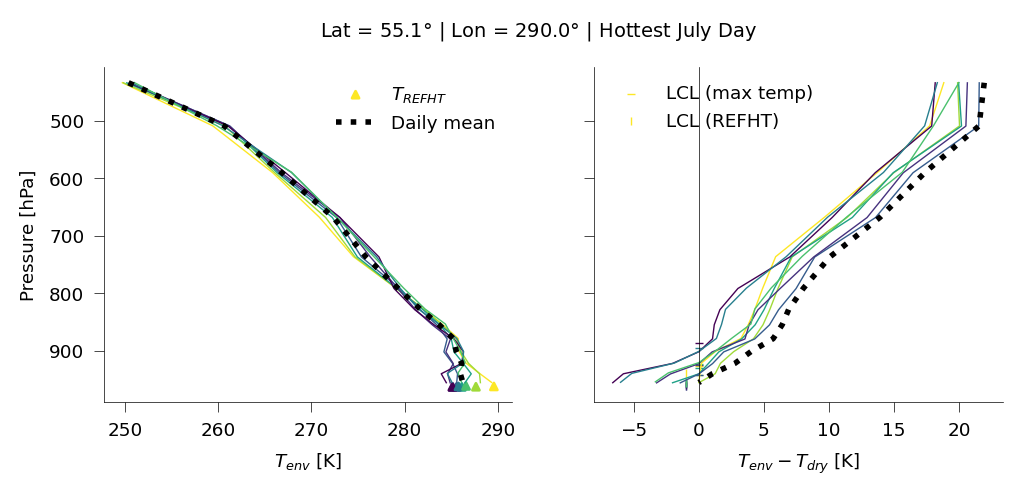

In [191]:
lat_loc = 60
lon_loc = 50
lat_loc = 40
lon_loc = 355
lat_loc = 55.35
lon_loc = 360-70
ds_loc = ds_hot.sel(lat=lat_loc, lon=lon_loc, method='nearest')
ds_loc['p'] = cesm.get_pressure(ds_loc.PS, p0, hyam, hybm)
t_max_lev_ind = ds_loc.T.argmax(dim='lev')
ds_loc['p_lcl'], ds_loc['t_lcl'] = lcl_metpy(ds_loc.T.isel(lev=t_max_lev_ind).fillna(0), ds_loc.Q.isel(lev=t_max_lev_ind).fillna(0),
                                             ds_loc.p.isel(lev=t_max_lev_ind).fillna(0))
ds_loc['p_lcl_REFHT'], ds_loc['t_lcl_REFHT'] = lcl_metpy(ds_loc.TREFHT.fillna(0), ds_loc.QREFHT.fillna(0),
                                                         ds_loc.PS.fillna(0))
for var in ds_loc:
    if 'lev' in ds_loc[var].dims:
        ds_loc[var] = ds_loc[var].where(ds_loc.p > 400 * 100)

fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 5.8)

# Normalize over the range of the dataset
norm = matplotlib.colors.Normalize(vmin=0, vmax=ds_loc.hour.size - 1)
# Get indices that would sort the array
sorted_indices = np.argsort(ds_loc.TREFHT.values)
# Create an array of ranks
ranks = np.empty_like(sorted_indices)
ranks[sorted_indices] = np.arange(ds_loc.hour.size)  # coldest=0, hottest=len-1
# Choose a colormap
cmap = matplotlib.cm.get_cmap('viridis')

for i in range(ds_loc.hour.size):
    ax[0].plot(ds_loc.T.isel(hour=i), ds_loc.p.isel(hour=i) / 100, color=cmap(norm(ranks[i])))
    temp_dry = dry_profile_temp(ds_loc.T.isel(hour=i).max(), ds_loc.p.isel(hour=i, lev=ds_loc.T.isel(hour=i).argmax()),
                                ds_loc.p.isel(hour=i))
    ax[1].plot(ds_loc.T.isel(hour=i) - temp_dry, ds_loc.p.isel(hour=i) / 100, color=cmap(norm(ranks[i])))
    ax[1].scatter(0, ds_loc.p_lcl.isel(hour=i)/100, color=cmap(norm(ranks[i])), marker='_', s=10,
               label='LCL (max temp)' if i==0 else None)
    ax[1].scatter(-1, ds_loc.p_lcl_REFHT.isel(hour=i)/100, color=cmap(norm(ranks[i])), marker='|', s=10,
               label='LCL (REFHT)' if i==0 else None)
ax[0].scatter(ds_loc.TREFHT, ds_loc.PS / 100, c=ranks, cmap=cmap, marker='^', label='$T_{REFHT}$')
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].plot(ds_loc.T.mean(dim='hour'), ds_loc.p.mean(dim='hour') / 100, color='k', linestyle=':', lw=2, label='Daily mean')
temp_dry = dry_profile_temp(ds_loc.T.mean(dim='hour').max(),
                            ds_loc.p.mean(dim='hour').isel(lev=ds_loc.T.mean(dim='hour').argmax()),
                            ds_loc.p.mean(dim='hour'))
ax[1].plot(ds_loc.T.mean(dim='hour') - temp_dry, ds_loc.p.mean(dim='hour') / 100, color='k', linestyle=':', lw=2)
ax[0].invert_yaxis()
ax[0].set_xlabel('$T_{env}$ [K]')
ax[1].set_xlabel('$T_{env} - T_{dry}$ [K]')
ax[0].set_ylabel('Pressure [hPa]')
ax[0].legend()
ax[1].legend(loc='upper left')
update_fontsize(fig)
fig.suptitle(f'Lat = {ds_loc.lat:.1f}$\degree$ | Lon = {ds_loc.lon:.1f}$\degree$ |'
             f' Hottest July Day', y=0.99, fontsize=7)
plt.show()

In [231]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180,180.01,60), grid_lat=np.asarray([40, 65])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    return ax

def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

In [227]:
ds_hot_daily_max = ds_hot.isel(hour=ds_hot.TREFHT.argmax(dim='hour'))
# ds_hot_daily_max = ds_hot.mean(dim='hour')
ds_hot_daily_max['p'] = cesm.get_pressure(ds_hot_daily_max.PS, p0, hyam, hybm)

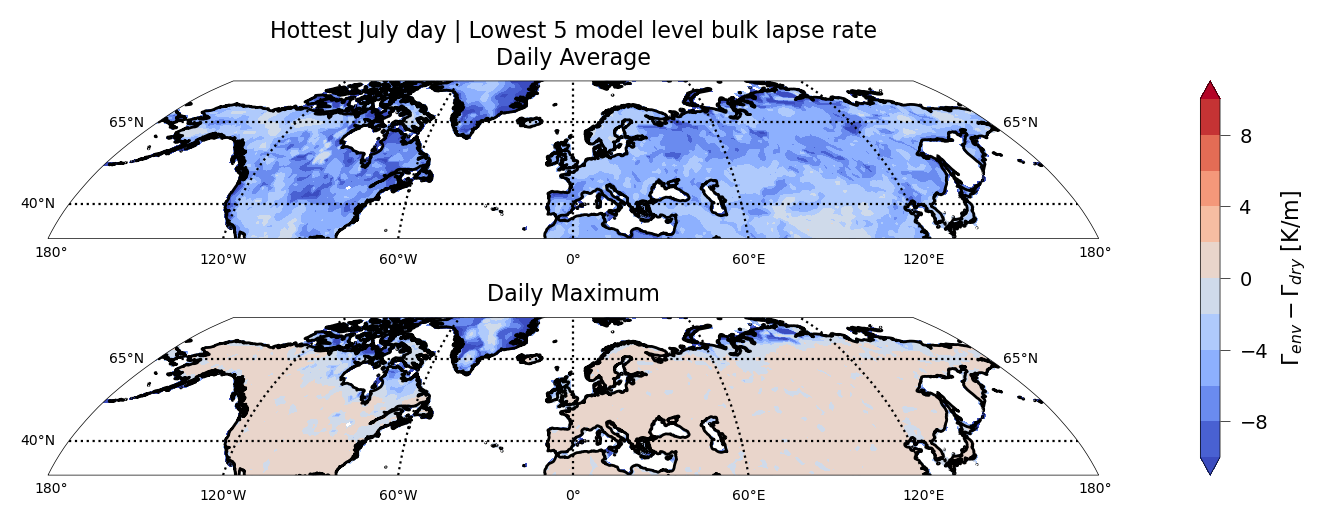

In [249]:
ds_use = [ds_hot.mean(dim='hour'), ds_hot.isel(hour=ds_hot.TREFHT.argmax(dim='hour'))]
n_level_lapse = 5
for i in range(len(ds_use)):
    ds_use[i]['p'] = cesm.get_pressure(ds_use[i].PS, p0, hyam, hybm)
    ds_use[i]['lapse_low'] = get_bulk_lapse_rate(ds_use[i].T.isel(lev=-1), ds_use[i].T.isel(lev=-n_level_lapse),
                                                 ds_use[i].p.isel(lev=-1), ds_use[i].p.isel(lev=-n_level_lapse))*1000
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
fig_resize(fig, 10, ar=8)
for ax_use in ax:
    initialize_ax_projection(ax_use)
contour_lev = np.linspace(-10, 10, 11)
for i in range(len(ds_use)):
    im = plot_contour_projection(ax[i], ds_use[i].lapse_low.where(lsm) - lapse_dry*1000, levels=contour_lev, cmap='coolwarm')
plt.colorbar(im, ax=ax.ravel(), label='$\Gamma_{env} - \Gamma_{dry}$ [K/m]')
ax[0].set_title(f'Hottest July day | Lowest {n_level_lapse} model level bulk lapse rate\nDaily Average')
ax[1].set_title('Daily Maximum')
plt.show()